In [31]:
import os
import sys
module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [32]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jaxfin.models.gbm import MultiGeometricBrownianMotion
from jaxfin.price_engine.black_scholes import european_price

from src.spread import margrabe_deltas, margrabe_gammas, margrabe
from src.experimental.auto_diff_greeks import bs_gamma, bs_delta
plt.style.use(['science','no-latex'])

SEED = 42

In [33]:
s0 = jnp.array([100, 100])
means = jnp.array([0.0, 0.0])
vols = jnp.array([0.2, 0.3])
correlation = jnp.array([[1, 0.2], [0.2, 1]], dtype=jnp.float32)

gbm = MultiGeometricBrownianMotion(s0, means, vols, correlation, dtype=jnp.float32)

In [53]:
expiration = 1.0
expiration_1 = 1.1
N = 252
dt = expiration / N
n_simulation = 1

stock_path = gbm.simulate_paths(SEED, expiration, N, n_simulation)

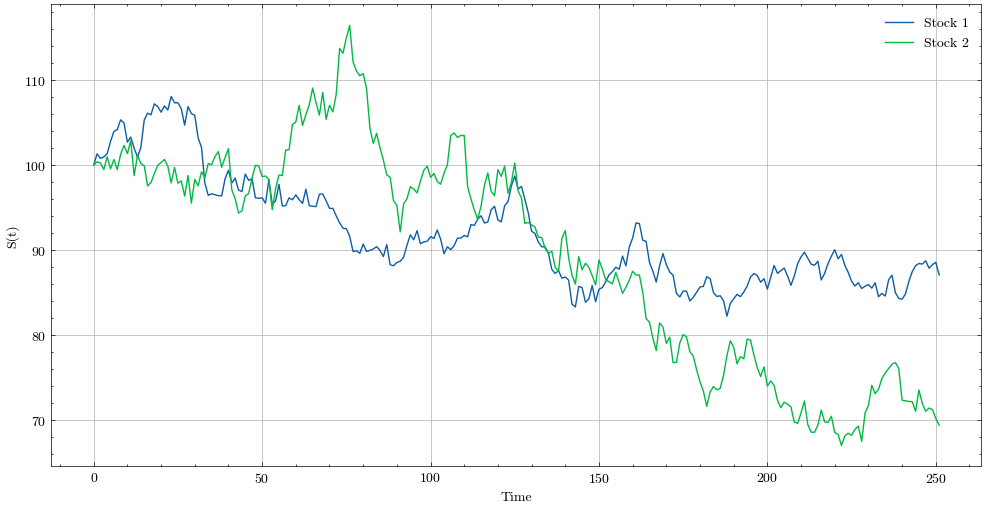

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(stock_path[:, :, 0], label='Stock 1')
plt.plot(stock_path[:, :, 1], label='Stock 2')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.legend()
plt.show()

In [55]:
K_2 = stock_path[0, 0, 0]
K_1 = stock_path[0, 0, 1]
r = 0.0

In [56]:
gamma_f2 = bs_gamma(stock_path[0, 0, 1], K_2, jnp.asarray(r), vols[1], jnp.asarray(expiration_1))
deltas_f2 = jnp.asarray([bs_delta(stock_path[i, 0, 1], K_2, jnp.asarray(r), vols[1], jnp.asarray(expiration_1) - i * dt) for i in range(N)])
calls_f2 = jnp.asarray([european_price(stock_path[i, 0, 1], K_2, expiration_1 - i * dt, vols[1], r, dtype=jnp.float32) for i in range(N)])

In [57]:
gamma_f1 = bs_gamma(stock_path[0, 0, 0], K_1, jnp.asarray(r), vols[0], jnp.asarray(expiration_1))
deltas_f1 = jnp.asarray([bs_delta(stock_path[i, 0, 0], K_1, jnp.asarray(r), vols[0], jnp.asarray(expiration_1) - i * dt) for i in range(N)])
calls_f1 = jnp.asarray([european_price(stock_path[i, 0, 0], K_1, expiration_1 - i * dt, vols[0], r, dtype=jnp.float32) for i in range(N)])

In [58]:
spread_deltas = jnp.asarray([margrabe_deltas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_gammas = jnp.asarray([margrabe_gammas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

In [59]:
x_f2 = spread_gammas[0, 1] / gamma_f2
x_f1 = spread_gammas[0, 0] / gamma_f1

In [60]:
x_2 = deltas_f2 * x_f2 - spread_deltas[:, 1]
x_1 = deltas_f1 * x_f1 - spread_deltas[:, 0]

In [61]:
spread_value = jnp.asarray([margrabe(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration- i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

In [62]:
b = [spread_value[0] - (x_f2 * calls_f2[0] + x_f1 * calls_f1[0] + x_1[0] * stock_path[0, 0, 0] + x_2[0] * stock_path[0, 0, 1])]
vs = [spread_value[0]]
delta_1_hp = x_f1 * deltas_f1 - x_1
delta_2_hp = x_f2 * deltas_f2 - x_2

for i in range(1, N):
    vs.append(x_f2 * calls_f2[i] + x_f1 * calls_f1[i] + x_1[i - 1] * stock_path[i, 0, 0] + x_2[i - 1] * stock_path[i, 0, 1] + b[i - 1])
    b.append(vs[i] - (x_f2 * calls_f2[i] + x_f1 * calls_f1[i] + x_1[i] * stock_path[i, 0, 0] + x_2[i] * stock_path[i, 0, 1]))

hedge_error = jnp.asarray(vs) - jnp.maximum(stock_path[:, 0, 1] - stock_path[:, 0, 0], 0)

In [63]:
print('The final hedge error is: ', hedge_error[-1])

The final hedge error is:  9.47746


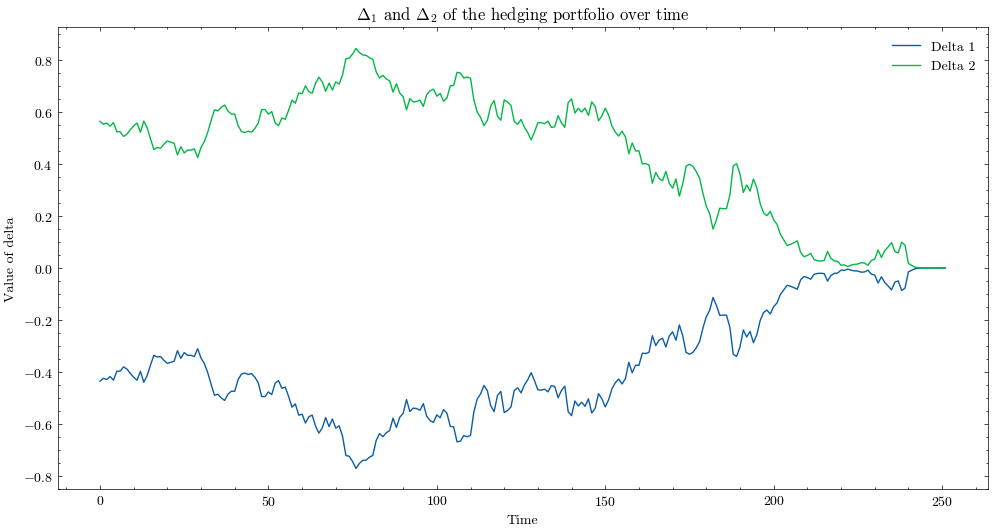

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(delta_1_hp, label='Delta 1')
plt.plot(delta_2_hp, label='Delta 2')
plt.title(r'$\Delta_1$ and $\Delta _2$ of the hedging portfolio over time')
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.legend()
plt.show()

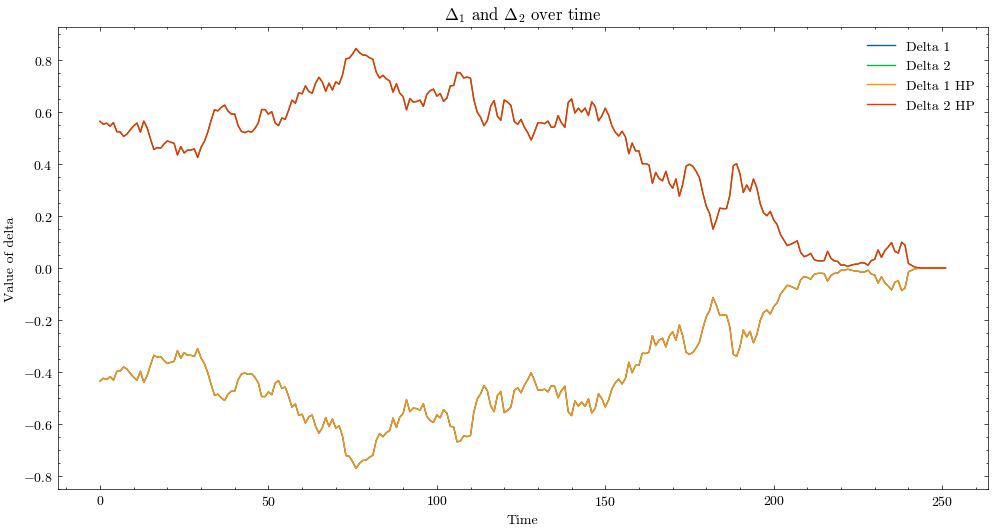

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(spread_deltas[:, 0], label='Delta 1')
plt.plot(spread_deltas[:, 1], label='Delta 2')
plt.plot(delta_1_hp, label='Delta 1 HP')
plt.plot(delta_2_hp, label='Delta 2 HP')
plt.title(r'$\Delta_1$ and $\Delta _2$ over time')
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.legend()
plt.show()

In [66]:
cross_gammas = jnp.asarray([margrabe_cross_gamma(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
gammas = jnp.asarray([margrabe_gammas(stock_path[i, 0, 0], stock_path[i, 0, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])

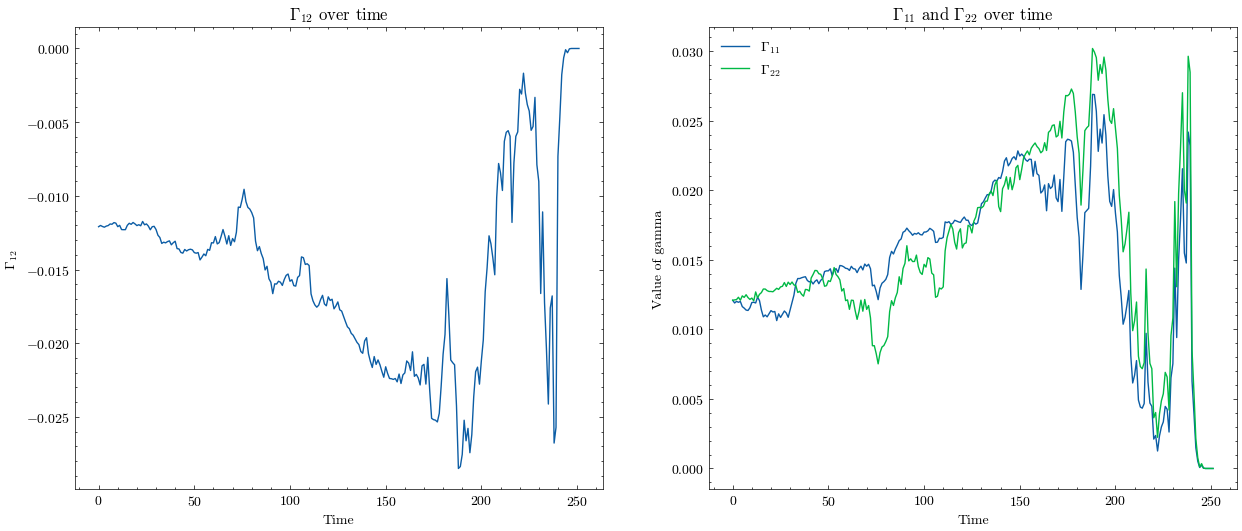

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(cross_gammas[:, 0])
axs[0].set_title(r'$\Gamma_{12}$ over time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel(r'$\Gamma_{12}$')

axs[1].plot(gammas[:, 0], label=r'$\Gamma_{11}$')
axs[1].plot(gammas[:, 1], label=r'$\Gamma_{22}$')
axs[1].set_title(r'$\Gamma_{11}$ and $\Gamma_{22}$ over time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value of gamma')
axs[1].legend()

plt.show()

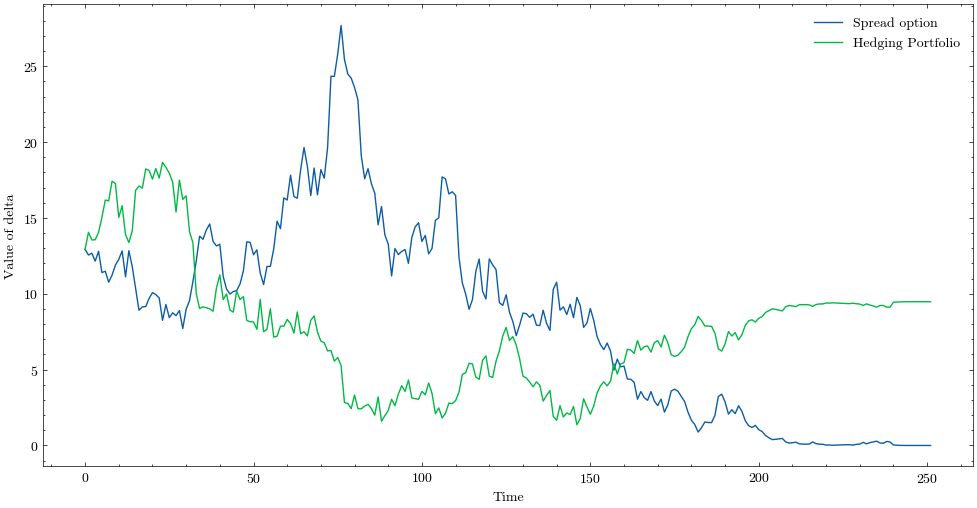

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(spread_value, label='Spread option')
plt.plot(vs, label='Hedging Portfolio')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value of delta')
plt.show()

## Multiple simulations

In [12]:
n_simulation = 1000

stock_paths = gbm.simulate_paths(SEED, expiration, N, n_simulation)

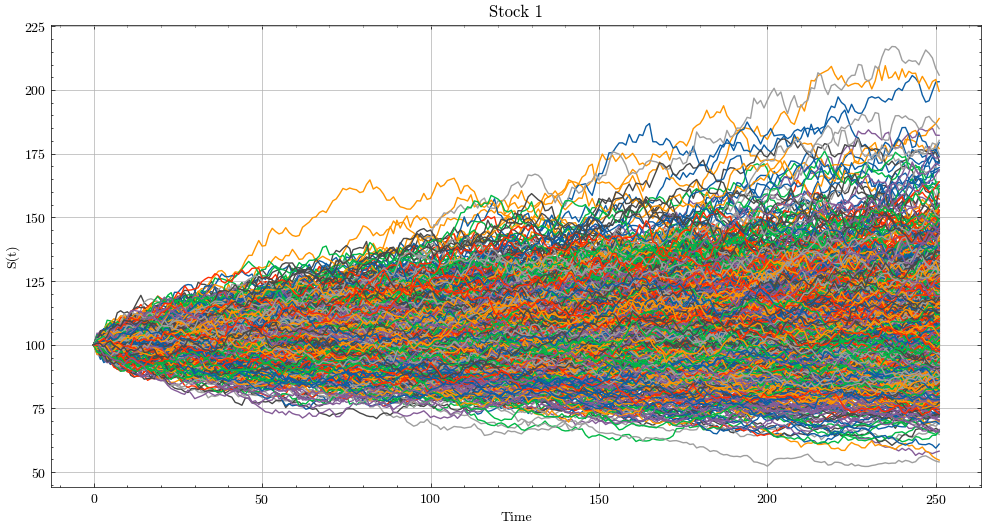

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(stock_paths[:, :, 0])
plt.title('Stock 1')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

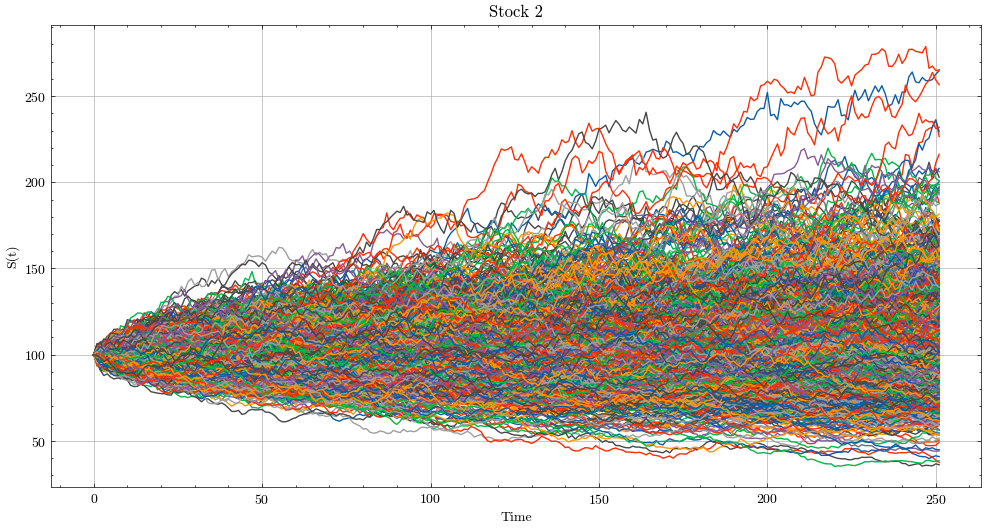

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(stock_paths[:, :, 1])
plt.title('Stock 2')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [15]:
vmap_deltas = vmap(margrabe_deltas, in_axes=(0, 0, None, None, None, None))

In [16]:
deltas = jnp.asarray([vmap_deltas(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
spread_value = jnp.asarray([margrabe(stock_paths[i, :, 0], stock_paths[i, :, 1], expiration - i * dt, vols[0], vols[1], correlation[0, 1]) for i in range(N)])
b = [spread_value[0, :] - deltas[0, 0, :] * stock_paths[0, :, 0] - deltas[0, 1, :] * stock_paths[0, :, 1]]
vs = [spread_value[0, :]]

for i in range(1, N):
    vs.append(deltas[i - 1, 0, :] * stock_paths[i, :, 0] + deltas[i - 1, 1, :] * stock_paths[i, :, 1] + b[i - 1])
    b.append(vs[i] - deltas[i, 0, :] * stock_paths[i, :, 0] - deltas[i, 1, :] * stock_paths[i, :, 1])

hedge_error = jnp.asarray(vs)[-1] - jnp.maximum(stock_paths[-1:, :, 1] - stock_paths[-1:, :, 0], 0)

In [17]:
jnp.mean(hedge_error[-1, :])

Array(0.1402342, dtype=float32)

In [18]:
jnp.std(hedge_error[-1, :]) / spread_value[0, 0]

Array(0.06059172, dtype=float32)